
***세부내용 'ImageNet Classification with Deep Convolutional
Neural Networks' 참고***


-논문 주요 내용-

***3. The Architecture***

총 5개의 convolution layer와 3개의 fully connected layer로 구성

 ***3.1 ReLU Nonlinearlity***

모든 layer의 activation function은 relu를 사용

***3.2 Training on Multiple GPUS***


![대체 텍스트](https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E)

논문에서 제안된 모델은 병렬처리하는 방식이었으나, 논문이 발표된 2012 보다 GPU의 성능이 upgrade되었기 때문에 병렬처리의 필요성이 없어졌다. (논문에서 사용된 GPU는 GTX580 with 3GB memory)
따라서 아래와 같은 model로 구현하겠다.

![대체 텍스트](https://cv-tricks.com/wp-content/uploads/2017/03/xalexnet_small-1.png.pagespeed.ic.u_mv-jhXMI.webp)

***3.3 Local Response Normalizaion***
relu 사용 시, 양수 방향으로 무한히 커질 가능성이 있어 너무 큰 값이 주변 값들을 무시하게 할 수도 있기 때문에 정규화과정을 수행

$$b_{x,y}^i = \dfrac{a_{x,y}^i}{ \left (k + \alpha \displaystyle\sum^{min(N-1, i+n/2)}_{j=max(0,i-n/2)}(a_{x,y}^j)^2 \right )^{\beta}}$$

$$k=2, n=5, \alpha=10^{-4}, \beta=0.75$$

***3.4 Overlapping Pooling***

Overlapping Pooling with 
stride = 2, filter_size = 3

*3.5 Overall*

구조 별 kerner_size는 ass1 참고


***4 Reducing Overfitting***


***4.1 Data Augmentation***

1)image augmentation -> horizontal reflection.

2)input data의 RGB channel에 PCA적용 

***4.2 Drop Out***

probability = 0.5로 FC1, FC2에 적용

***5. Detail of Learning***

stochastic gradient descent with batch_size = 128

momentum = 0.9

weight_decay = 0.0005

weight_initializaion = zero-mean Gaussian distribution (표준편자 = 0.01)

neuron_bias initializaion (2, 4, 5번째 ConV layer, 모든 FC layer) with constant = 1

learning_rate = 0.01


![대체 텍스트](https://github.com/minjung-s/Tobigs_13/blob/master/KakaoTalk_20200320_044749707.jpg?raw=true)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [0]:
print(tf.__version__)

2.1.0


keras.layers.Conv1D(filters, kernel_size, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [0]:
import tensorflow as tf

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer

In [18]:
num_calsses = 1000

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96,(11,11),strides=4,
                 padding='same', input_shape=(227,227,3)),
  tf.keras.layers.Conv2D(256,(5,5),strides=4,
                 padding='same', input_shape=(227,227,3)),
                 #Local
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2),     
  tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
  #local
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2), 
  tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_calsses,activation="softmax") 
])

optimizer = optimizers.SGD(lr=0.01, decay=5e-5, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 57, 57, 96)        34944     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 256)       614656    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 384)         885120    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 384)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 384)         1327488   
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 3, 3, 256)        

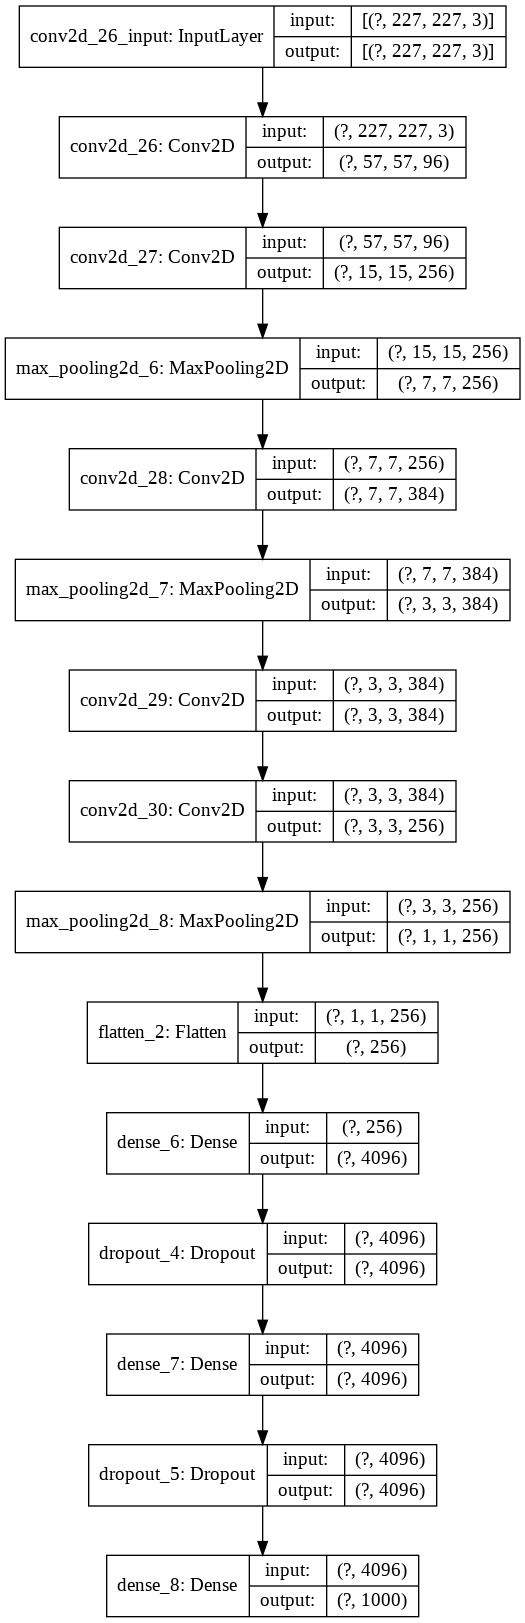

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

Local Response Normalizaion이 포함 된 model


출처 : https://datascienceschool.net/view-notebook/d19e803640094f76b93f11b850b920a4/

In [0]:
class LocalResponseNormalization(Layer):

    def __init__(self, n=5, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        _, r, c, f = self.shape 
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1,1), padding="same", pool_mode='avg')
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom 
    
    def compute_output_shape(self, input_shape):
        return input_shape 

In [15]:
input_shape = (224, 224, 3)

model_lrn = Sequential()
model_lrn.add(Conv2D(96, (11, 11), strides=4,
                 padding='same', input_shape=input_shape))
model_lrn.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model_lrn.add(LocalResponseNormalization(input_shape=model_lrn.output_shape[1:]))
model_lrn.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model_lrn.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model_lrn.add(LocalResponseNormalization(input_shape=model_lrn.output_shape[1:]))
model_lrn.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model_lrn.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model_lrn.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_lrn.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model_lrn.add(Flatten())
model_lrn.add(Dense(4096, activation='relu'))
model_lrn.add(Dropout(0.5))
model_lrn.add(Dense(4096, activation='relu'))
model_lrn.add(Dropout(0.5))
model_lrn.add(Dense(1000, activation='softmax'))

optimizer = optimizers.SGD(lr=0.01, decay=5e-5, momentum=0.9)
model_lrn.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model_lrn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)       614656    
_________________________________________________________________
local_response_normalization (None, 56, 56, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 27, 27, 384)       885120    
_________________________________________________________________
local_response_normalization (None, 27, 27, 384)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 384)      

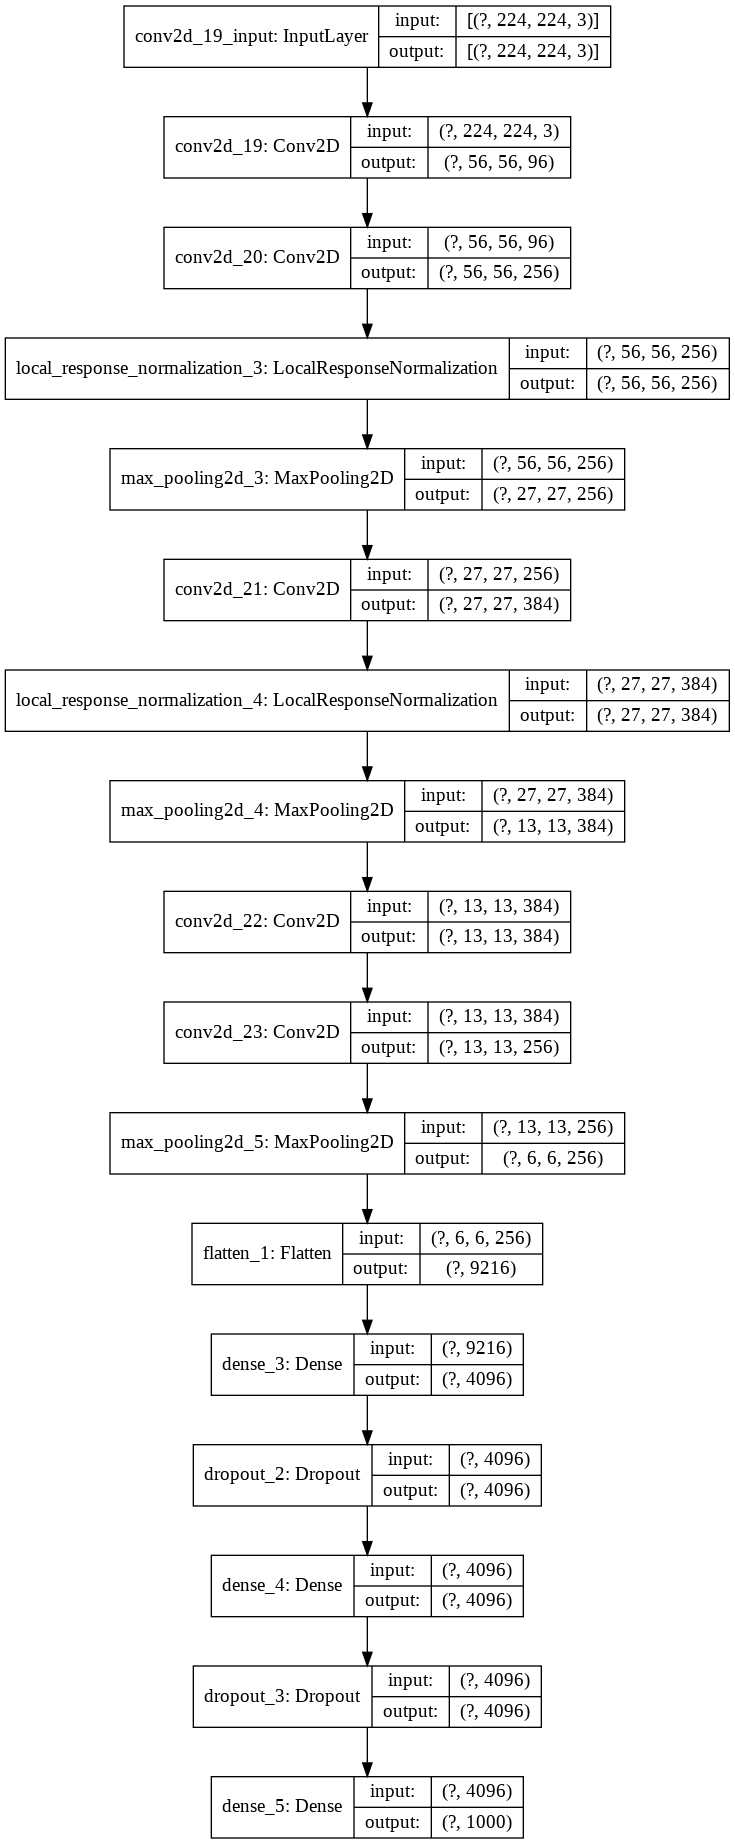

In [21]:
plot_model(model_lrn, to_file = 'model_lrn.png', show_shapes = True, show_layer_names = True)